# **Analysis of Music Features Dataset**

**The dataset is taken from [kaggle](https://www.kaggle.com/datasets/insiyeah/musicfeatures?select=data.csv) and the original author is user INSIYAH HAJOORI**


## **About the Dataset**

**Context**

A music genre is a conventional category that identifies pieces of music as belonging to a shared tradition or set of conventions. It is to be distinguished from musical form and musical style. The features extracted from these waves can help the machine distinguish between them.

**Content**

The features in this dataset are extracted from the dataset provided here which consists of 1000 audio tracks each 30 seconds long. It contains 10 genres, each represented by 100 tracks. The tracks are all 22050Hz Mono 16-bit audio files in .wav format. The code used to extract features is at [this](https://github.com/Insiyaa/Music-Tagging) GitHub repo. Features are extracted using [libROSA](https://librosa.org/doc/latest/index.html) library.

**Acknowledgements**

The credits to this dataset go to [MARSYAS](http://marsyas.info/).

**Inspiration**

Due to the artistic nature of music, the classifications are often arbitrary and controversial, and some genres may overlap. Train a model and know to which genre your favourite piece of music belong to.


## **Aim of Study**



The broad aim of this study will be to utilise the relevant features of the dataset and create a model that can predict the genre of a song based on these features.

The secondary aim of this study will be to test the effectiveness of different modeling methods, by comparing their errors (MSE, RMSE, R^2). 


## **Initializing the data**

In [1]:
#import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
from textblob import TextBlob
from sklearn.feature_selection import RFE

In [2]:
data_set = 'data/data.csv'
data_frame = pd.read_csv(data_set, index_col=0)
data_frame.head()

,tempo,beats,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
filename,,,,,,,,,,,,,,,,,,,,,
blues.00081.au,103.359375,50,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,107.334008,...,14.336612,-13.821769,7.562789,-6.181372,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues
blues.00022.au,95.703125,44,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,-233.860772,136.170239,...,-2.250578,3.959198,5.322555,0.812028,-1.107202,-4.556555,-2.436490,3.316913,-0.608485,blues
blues.00031.au,151.999081,75,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,-221.802549,110.843070,...,-13.037723,-12.652228,-1.821905,-7.260097,-6.660252,-14.682694,-11.719264,-11.025216,-13.387260,blues
blues.00012.au,184.570312,91,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,-207.208080,132.799175,...,-0.613248,0.384877,2.605128,-5.188924,-9.527455,-9.244394,-2.848274,-1.418707,-5.932607,blues
blues.00056.au,161.499023,74,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,-145.434568,102.829023,...,7.457218,-10.470444,-2.360483,-6.783623,2.671134,-4.760879,-0.949005,0.024832,-2.005315,blues


### **Cleaning the Dataset**

Cleaning the dataset involves dropping all null values and encoding object features into numeric values. Further, The cleaning process should involve dropping any unnecessary fields. 

In this case, there are no fields with null values, and 'Label' is a feature that has to be encoded, while 20 fields of Mel-frequency cepstral coefficients (MFCCs) will also be dropped so as to simplify this dataset.



In [3]:
encoder = OrdinalEncoder()

data_frame['genre'] = encoder.fit_transform(data_frame[['label']])

music_data = data_frame[['beats', 'tempo','chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'label', 'genre']]
music_data

,beats,tempo,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,label,genre
filename,,,,,,,,,,
blues.00081.au,50,103.359375,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,blues,0.0
blues.00022.au,44,95.703125,0.306451,0.113475,1156.070496,1497.668176,2170.053545,0.058613,blues,0.0
blues.00031.au,75,151.999081,0.253487,0.151571,1331.073970,1973.643437,2900.174130,0.042967,blues,0.0
blues.00012.au,91,184.570312,0.269320,0.119072,1361.045467,1567.804596,2739.625101,0.069124,blues,0.0
blues.00056.au,74,161.499023,0.391059,0.137728,1811.076084,2052.332563,3927.809582,0.075480,blues,0.0
...,...,...,...,...,...,...,...,...,...,...
rock.00017.au,59,123.046875,0.418812,0.166056,2312.030070,2060.825761,4528.197619,0.140588,rock,9.0
rock.00081.au,56,117.453835,0.335774,0.093676,2553.856706,2219.090892,5123.752351,0.136173,rock,9.0
rock.00004.au,45,103.359375,0.372834,0.208743,1345.850763,1841.748033,2939.265560,0.041099,rock,9.0


In [4]:
music_data.describe()

,beats,tempo,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,genre
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,57.138000,119.601702,0.378656,0.130929,2201.834226,2242.559613,4571.702159,0.103637,4.500000
std,14.225728,28.297367,0.081689,0.065685,715.961347,526.337663,1574.770035,0.041834,2.873719
min,18.000000,54.978391,0.171782,0.005276,569.930721,897.994319,749.062137,0.021701,0.000000
25%,47.000000,99.384014,0.319641,0.086625,1627.793931,1907.136505,3380.956639,0.070281,2.000000
50%,56.000000,117.453835,0.383075,0.122448,2209.468780,2221.408983,4658.671830,0.099539,4.500000
75%,65.250000,135.999178,0.435974,0.175793,2691.969702,2578.474352,5534.197785,0.132007,7.000000
max,117.000000,234.907670,0.663573,0.398012,4434.439444,3509.578677,8676.405868,0.274829,9.000000


### **Visualizing the Data**

C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Mean Beats')

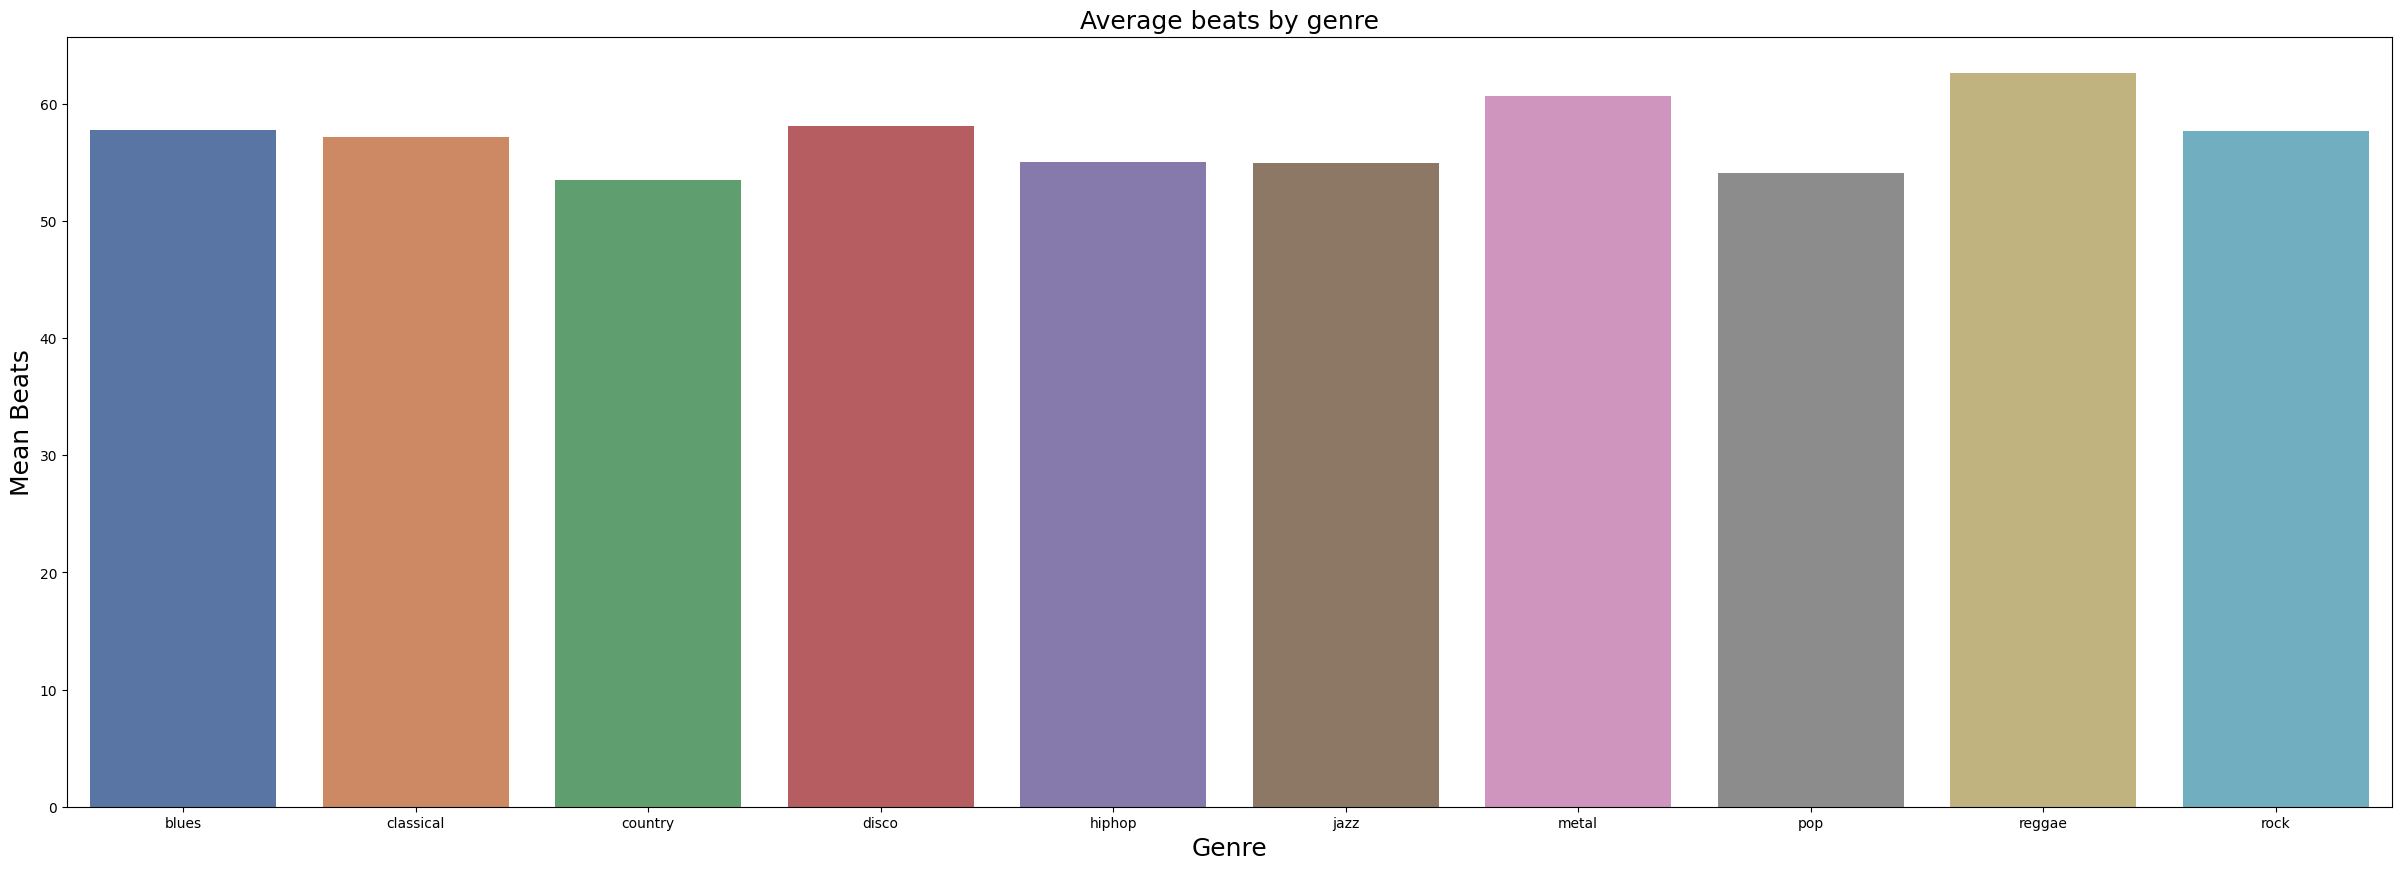

In [5]:
plt.figure(figsize=(30,10))

genres = music_data['label'].unique()

beats = [ music_data[music_data['label']==x].beats.mean() for x in genres ]

sns.barplot(x=genres, y=beats, palette="deep")

plt.title("Average beats by genre", fontsize = 18)

plt.xlabel('Genre', fontsize = 18)
plt.ylabel('Mean Beats', fontsize = 18)

C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Mean Tempo')

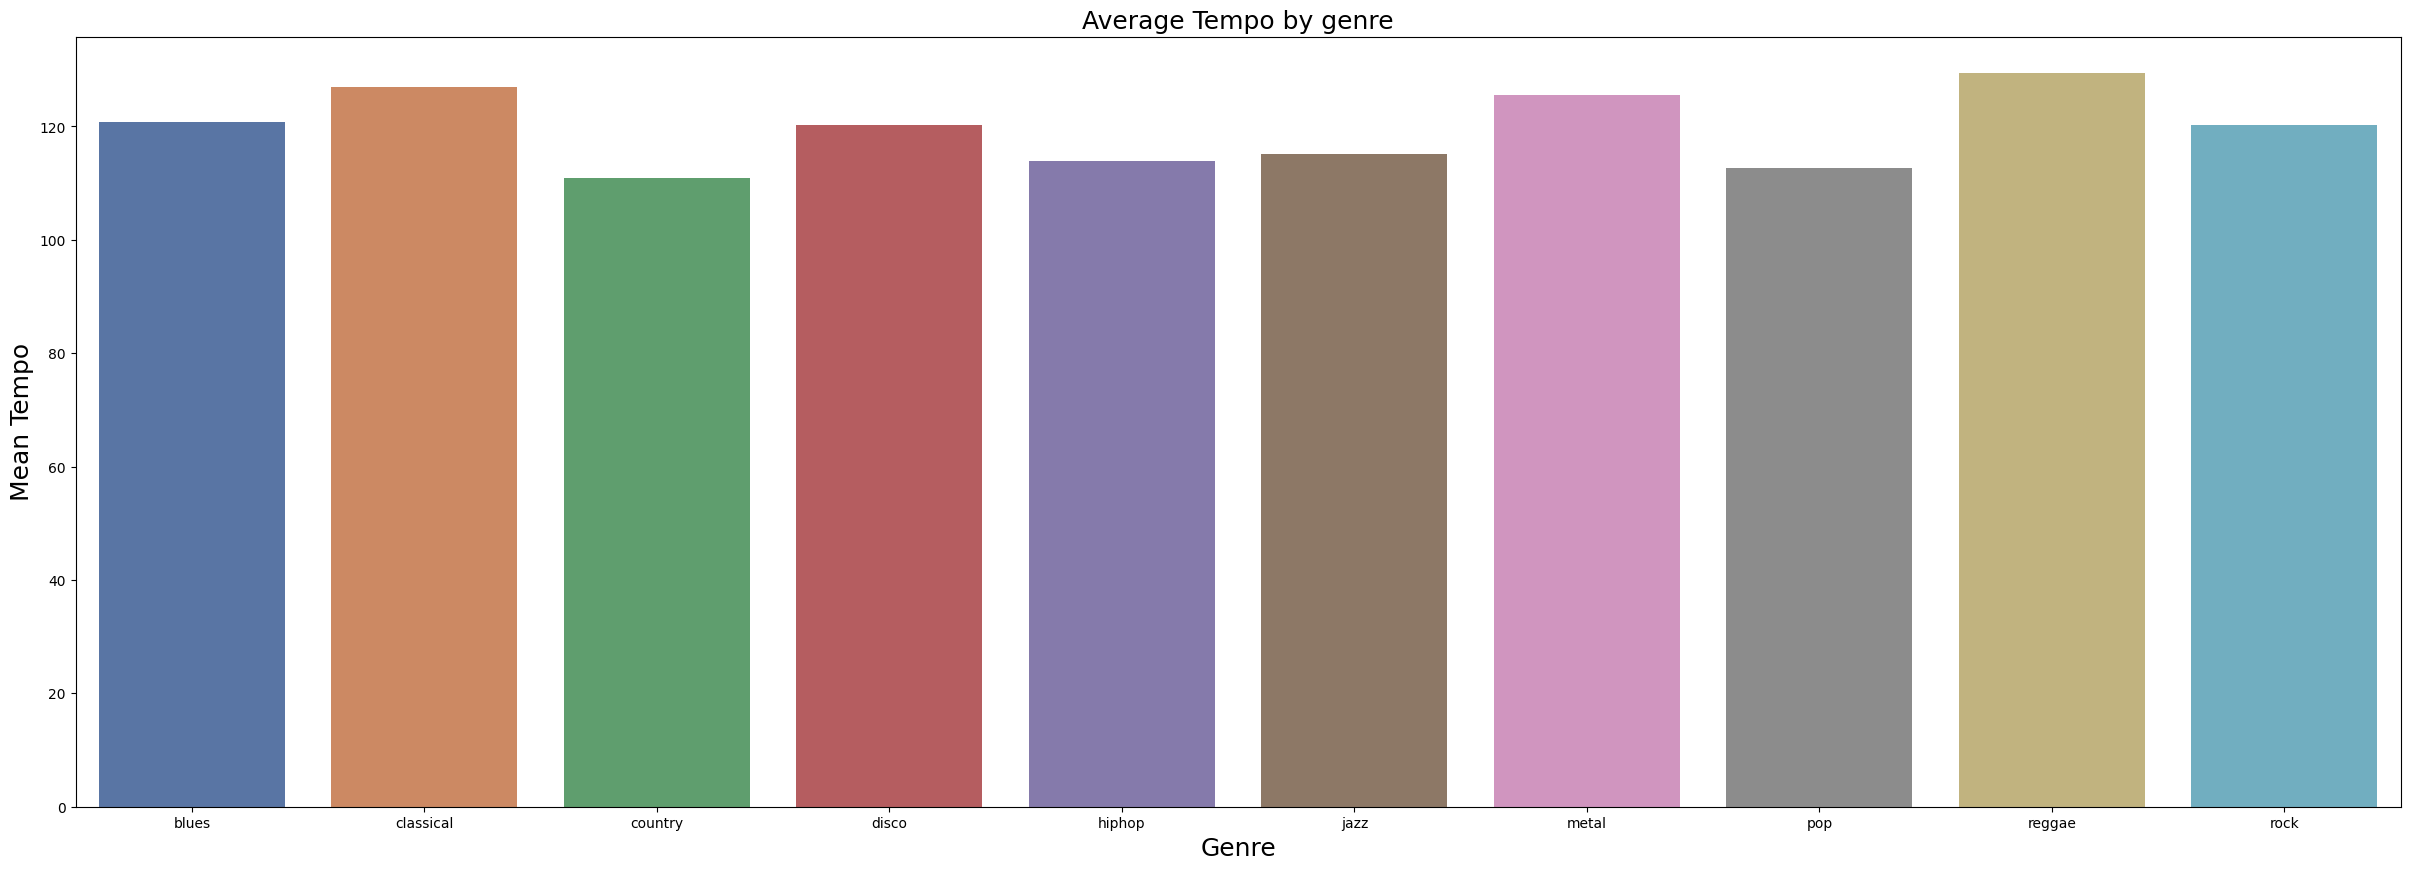

In [6]:
plt.figure(figsize=(30,10))

tempo = [ music_data[music_data['label']==x].tempo.mean() for x in genres ]

sns.barplot(x=genres, y=tempo, palette="deep")

plt.title("Average Tempo by genre", fontsize = 18)

plt.xlabel('Genre', fontsize = 18)
plt.ylabel('Mean Tempo', fontsize = 18)

C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Mean Chroma STFT')

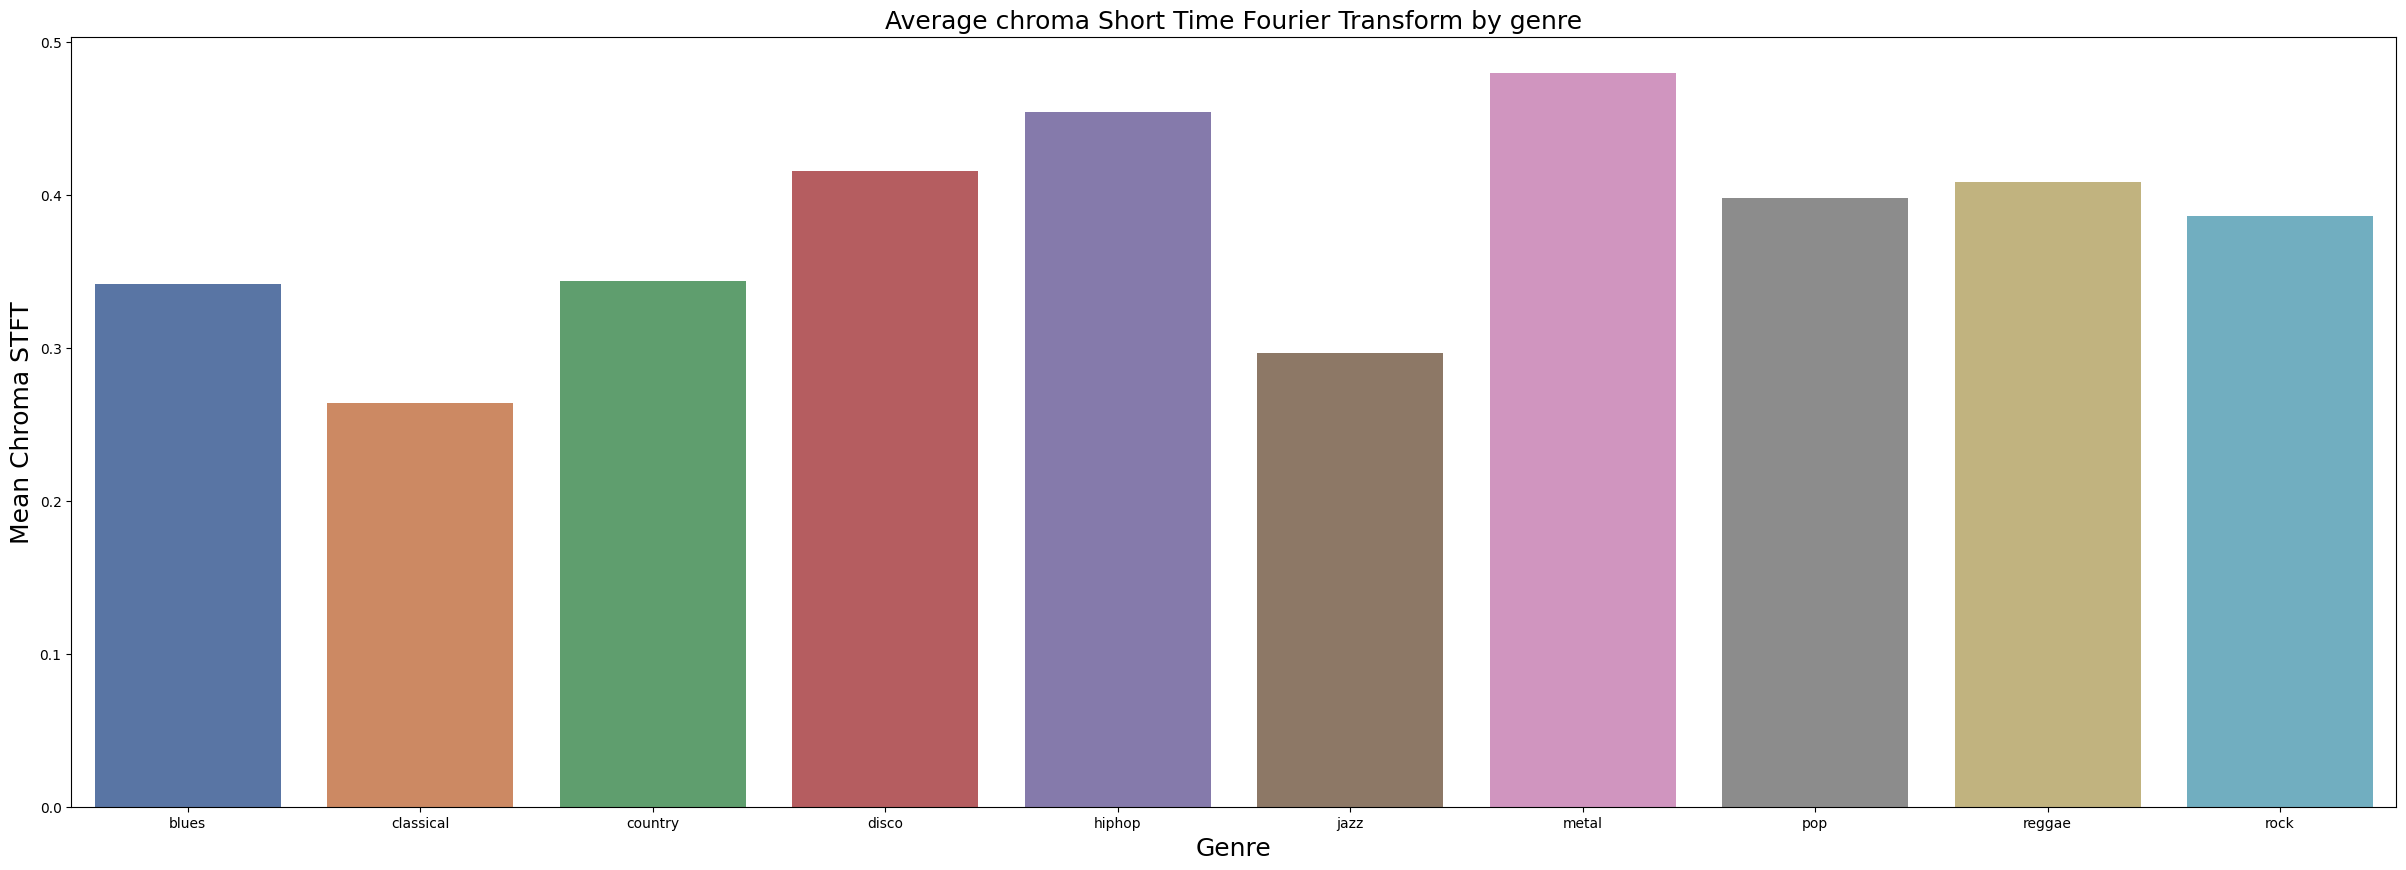

In [7]:
plt.figure(figsize=(30,10))

chroma_stft = [ music_data[music_data['label']==x].chroma_stft.mean() for x in genres ]

sns.barplot(x=genres, y=chroma_stft, palette="deep")

plt.title("Average chroma Short Time Fourier Transform by genre", fontsize = 18)

plt.xlabel('Genre', fontsize = 18)
plt.ylabel('Mean Chroma STFT', fontsize = 18)

C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Mean RMSE')

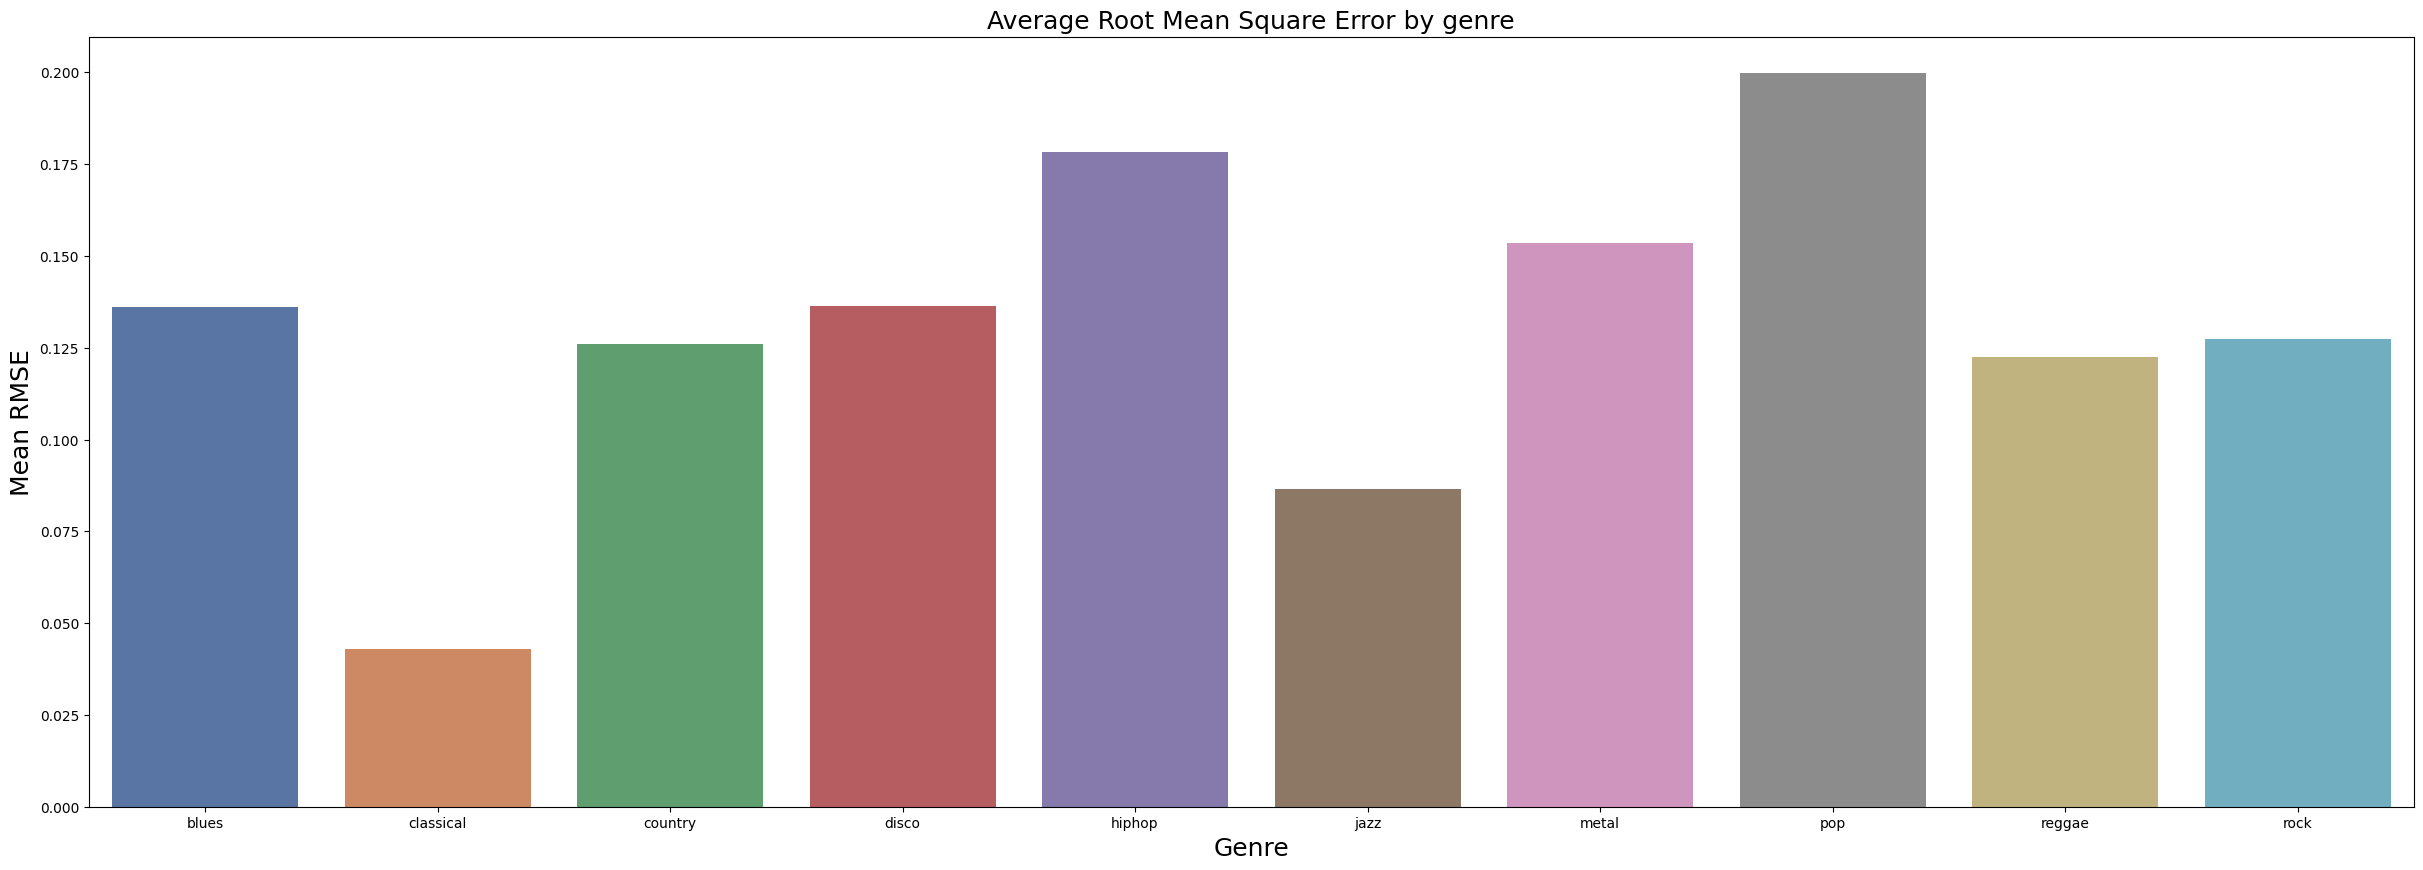

In [8]:
plt.figure(figsize=(30,10))

rmse = [ music_data[music_data['label']==x].rmse.mean() for x in genres ]

sns.barplot(x=genres, y=rmse, palette="deep")

plt.title("Average Root Mean Square Error by genre", fontsize = 18)

plt.xlabel('Genre', fontsize = 18)
plt.ylabel('Mean RMSE', fontsize = 18)

C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Mean Spectral Centroid')

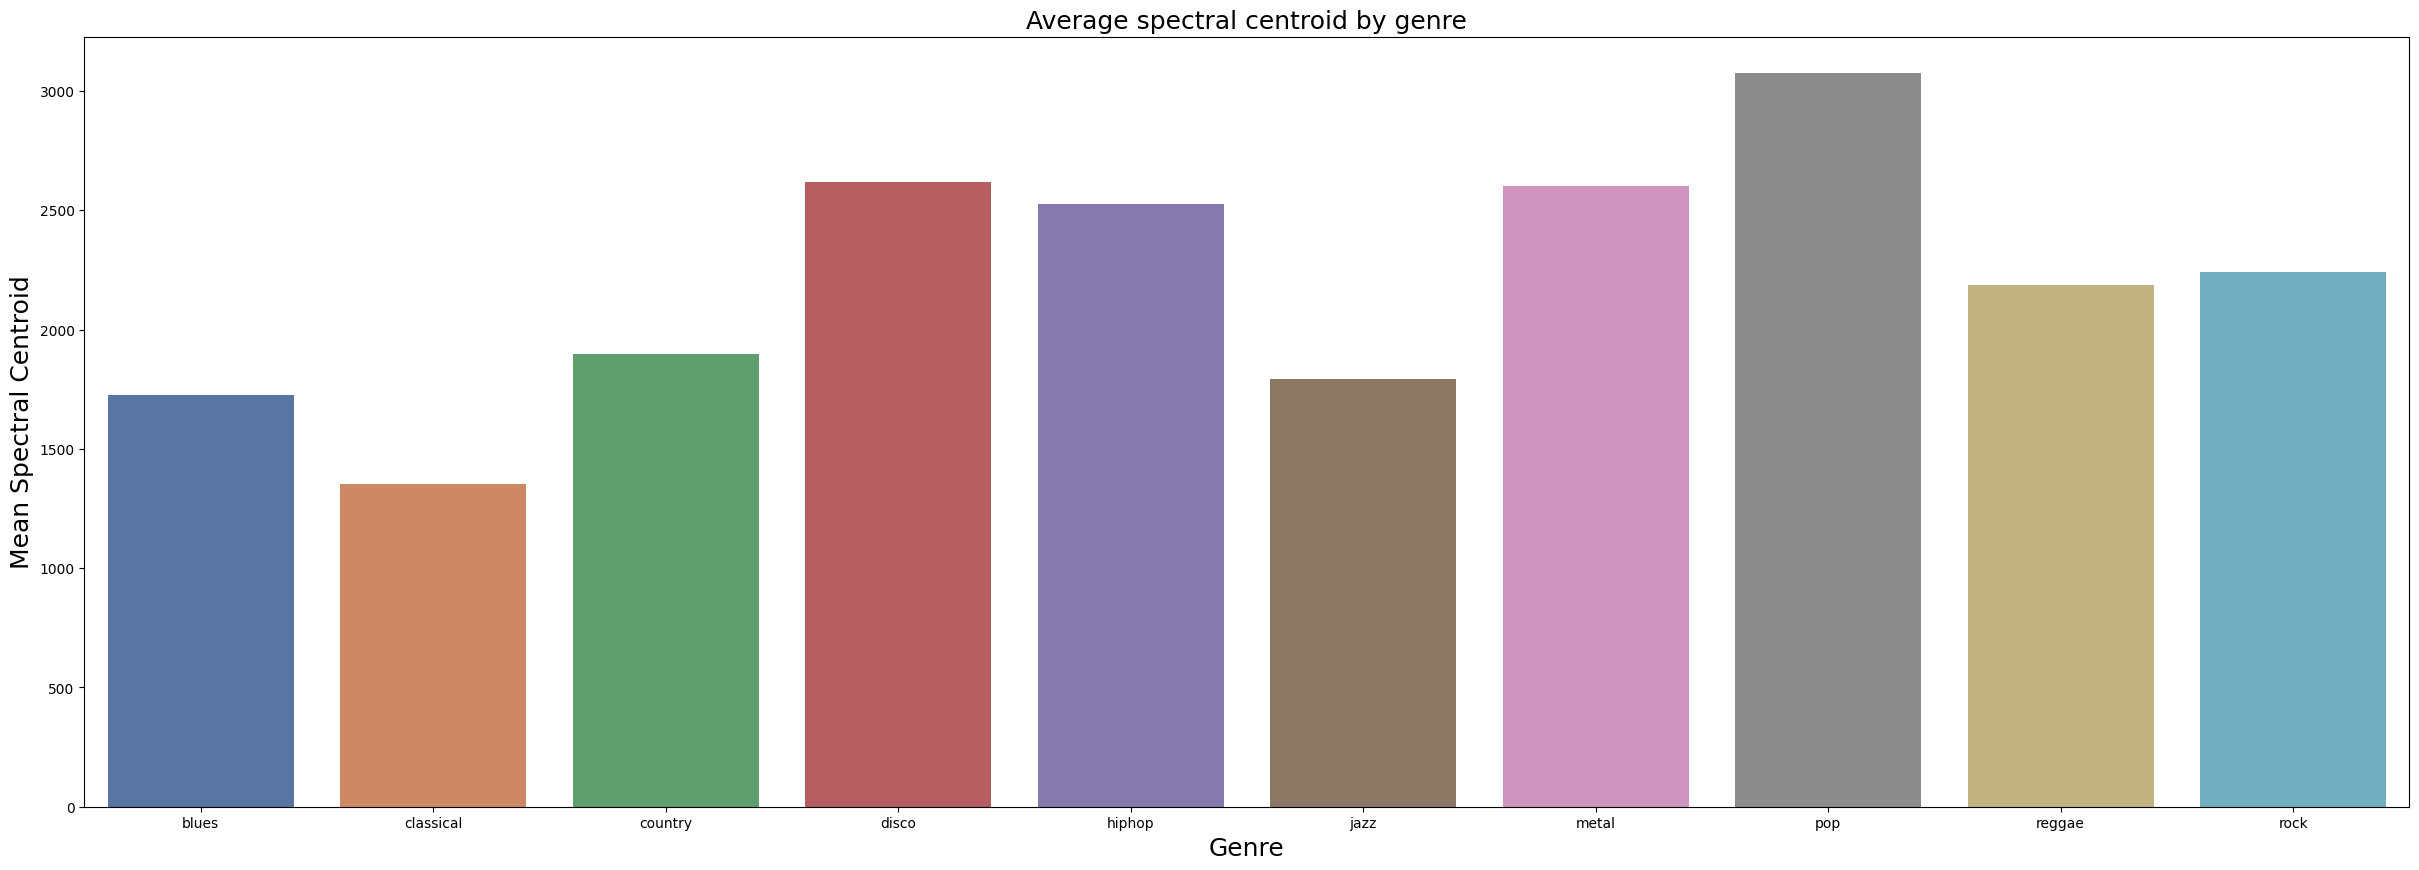

In [9]:
plt.figure(figsize=(30,10))

spectral_centroids = [ music_data[music_data['label']==x].spectral_centroid.mean() for x in genres ]

sns.barplot(x=genres, y=spectral_centroids, palette="deep")

plt.title("Average spectral centroid by genre", fontsize = 18)

plt.xlabel('Genre', fontsize = 18)
plt.ylabel('Mean Spectral Centroid', fontsize = 18)

C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Mean Spectral Bandwidth')

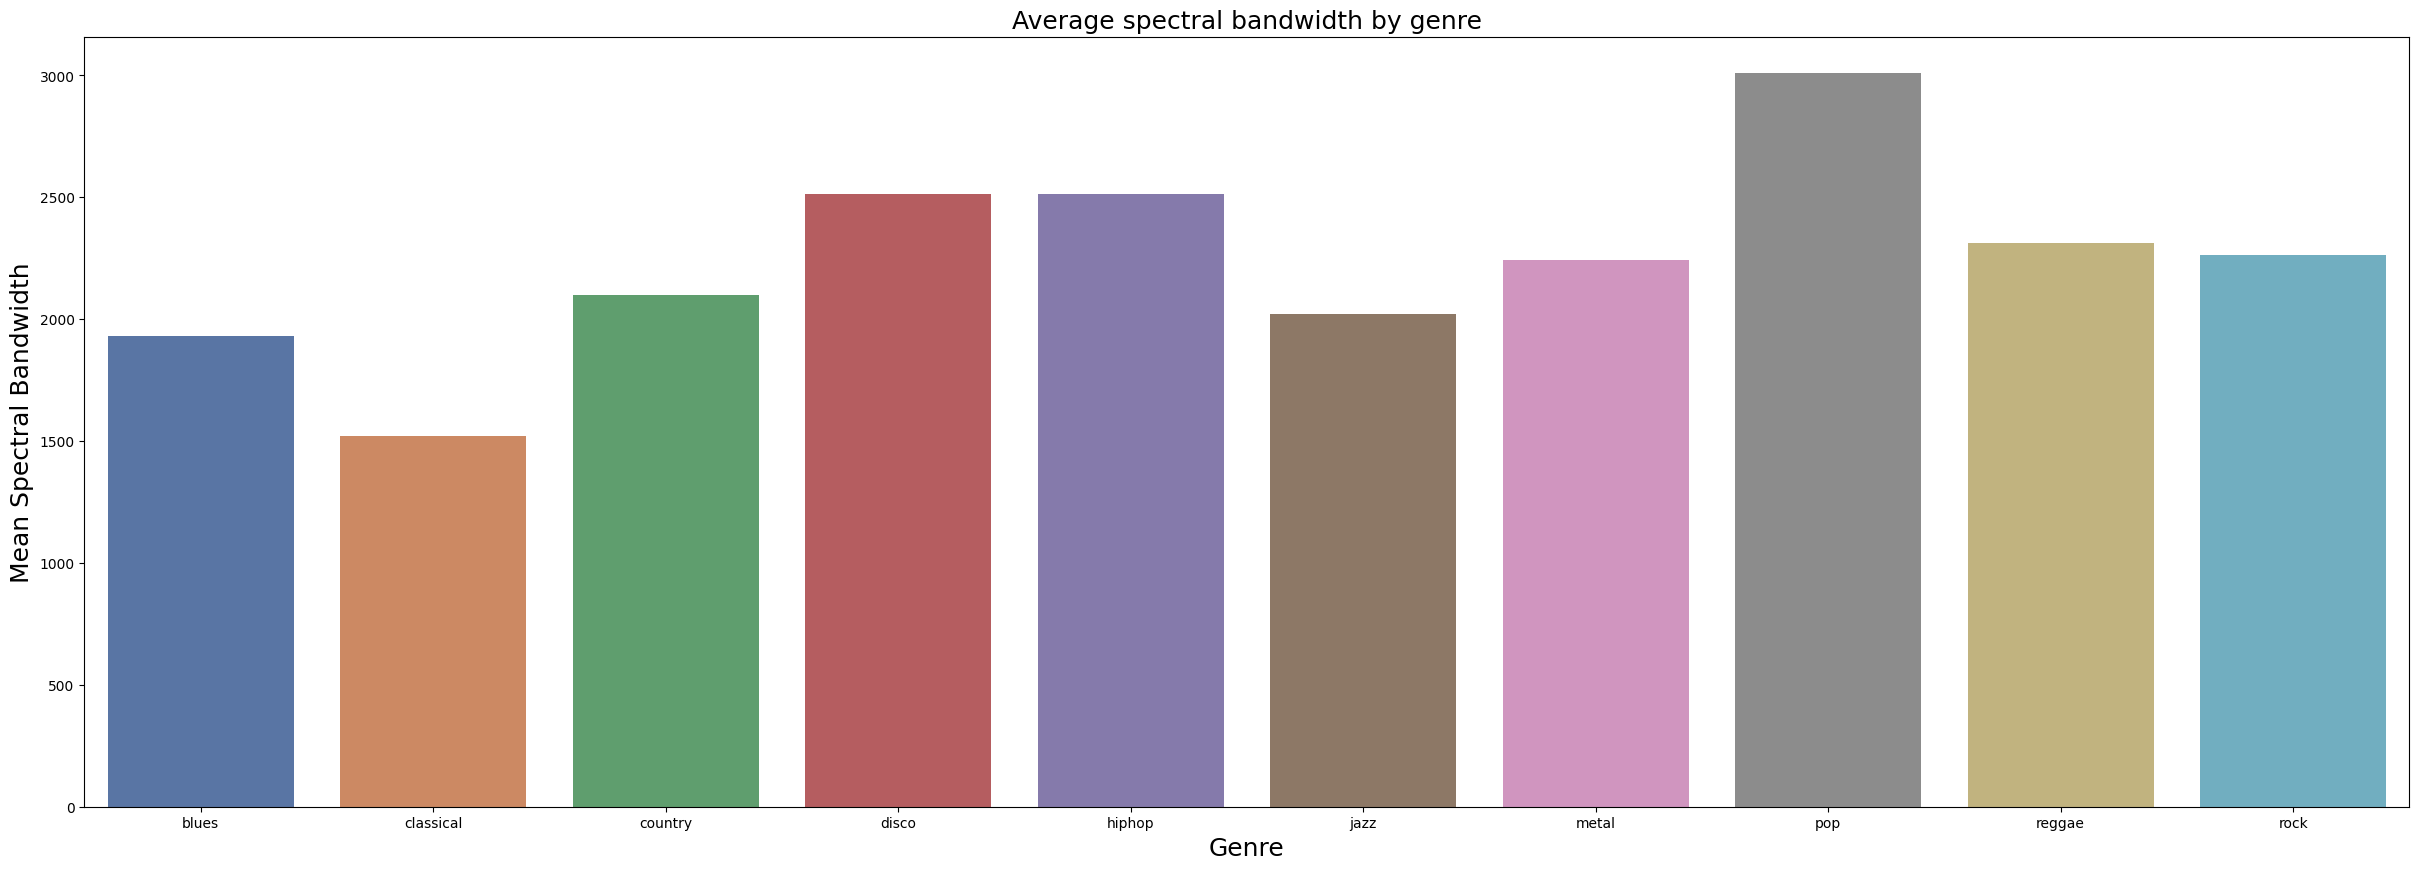

In [10]:
plt.figure(figsize=(30,10))

spectral_bandwidth = [ music_data[music_data['label']==x].spectral_bandwidth.mean() for x in genres ]

sns.barplot(x=genres, y=spectral_bandwidth, palette="deep")

plt.title("Average spectral bandwidth by genre", fontsize = 18)

plt.xlabel('Genre', fontsize = 18)
plt.ylabel('Mean Spectral Bandwidth', fontsize = 18)

C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Mean Rolloff')

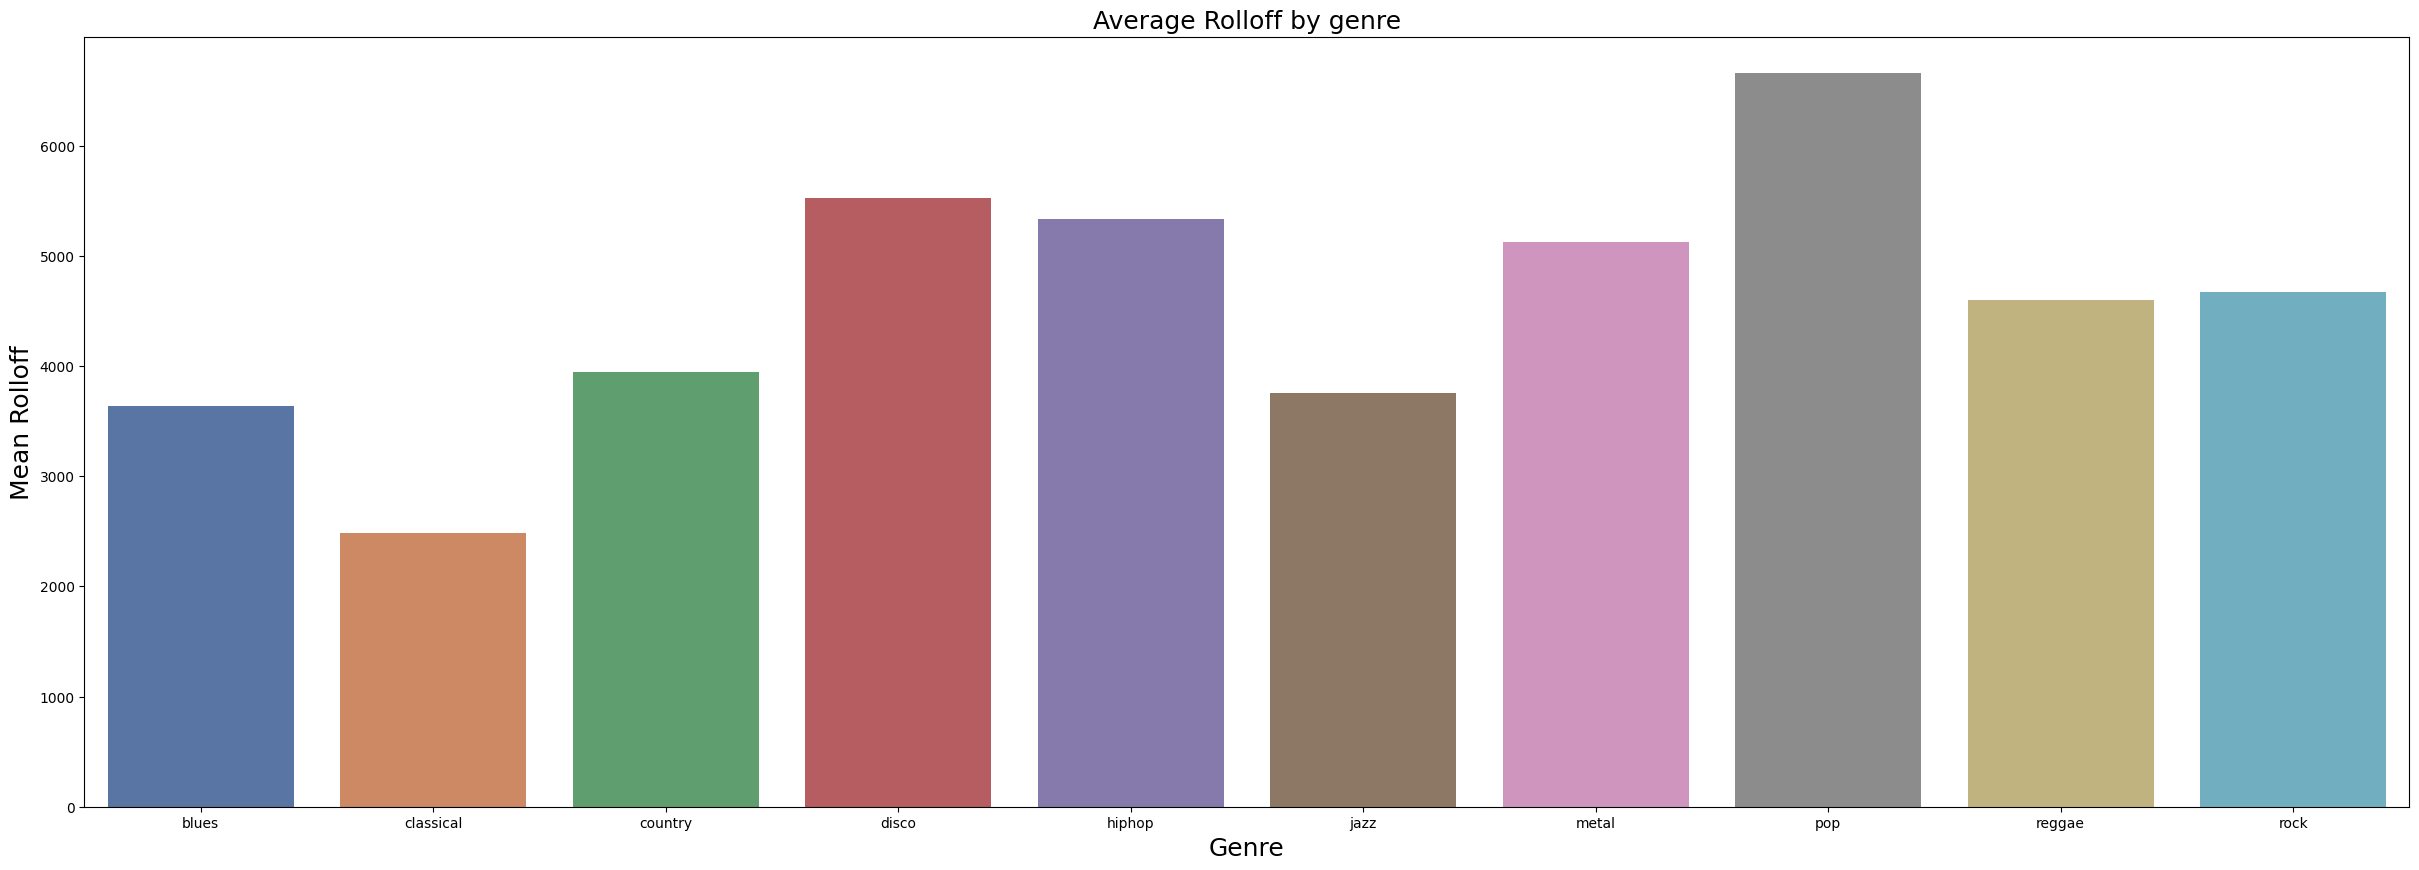

In [11]:
plt.figure(figsize=(30,10))

rolloff = [ music_data[music_data['label']==x].rolloff.mean() for x in genres ]

sns.barplot(x=genres, y=rolloff, palette="deep")

plt.title("Average Rolloff by genre", fontsize = 18)

plt.xlabel('Genre', fontsize = 18)
plt.ylabel('Mean Rolloff', fontsize = 18)

C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Victus\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Mean Zero Crossing Rate')

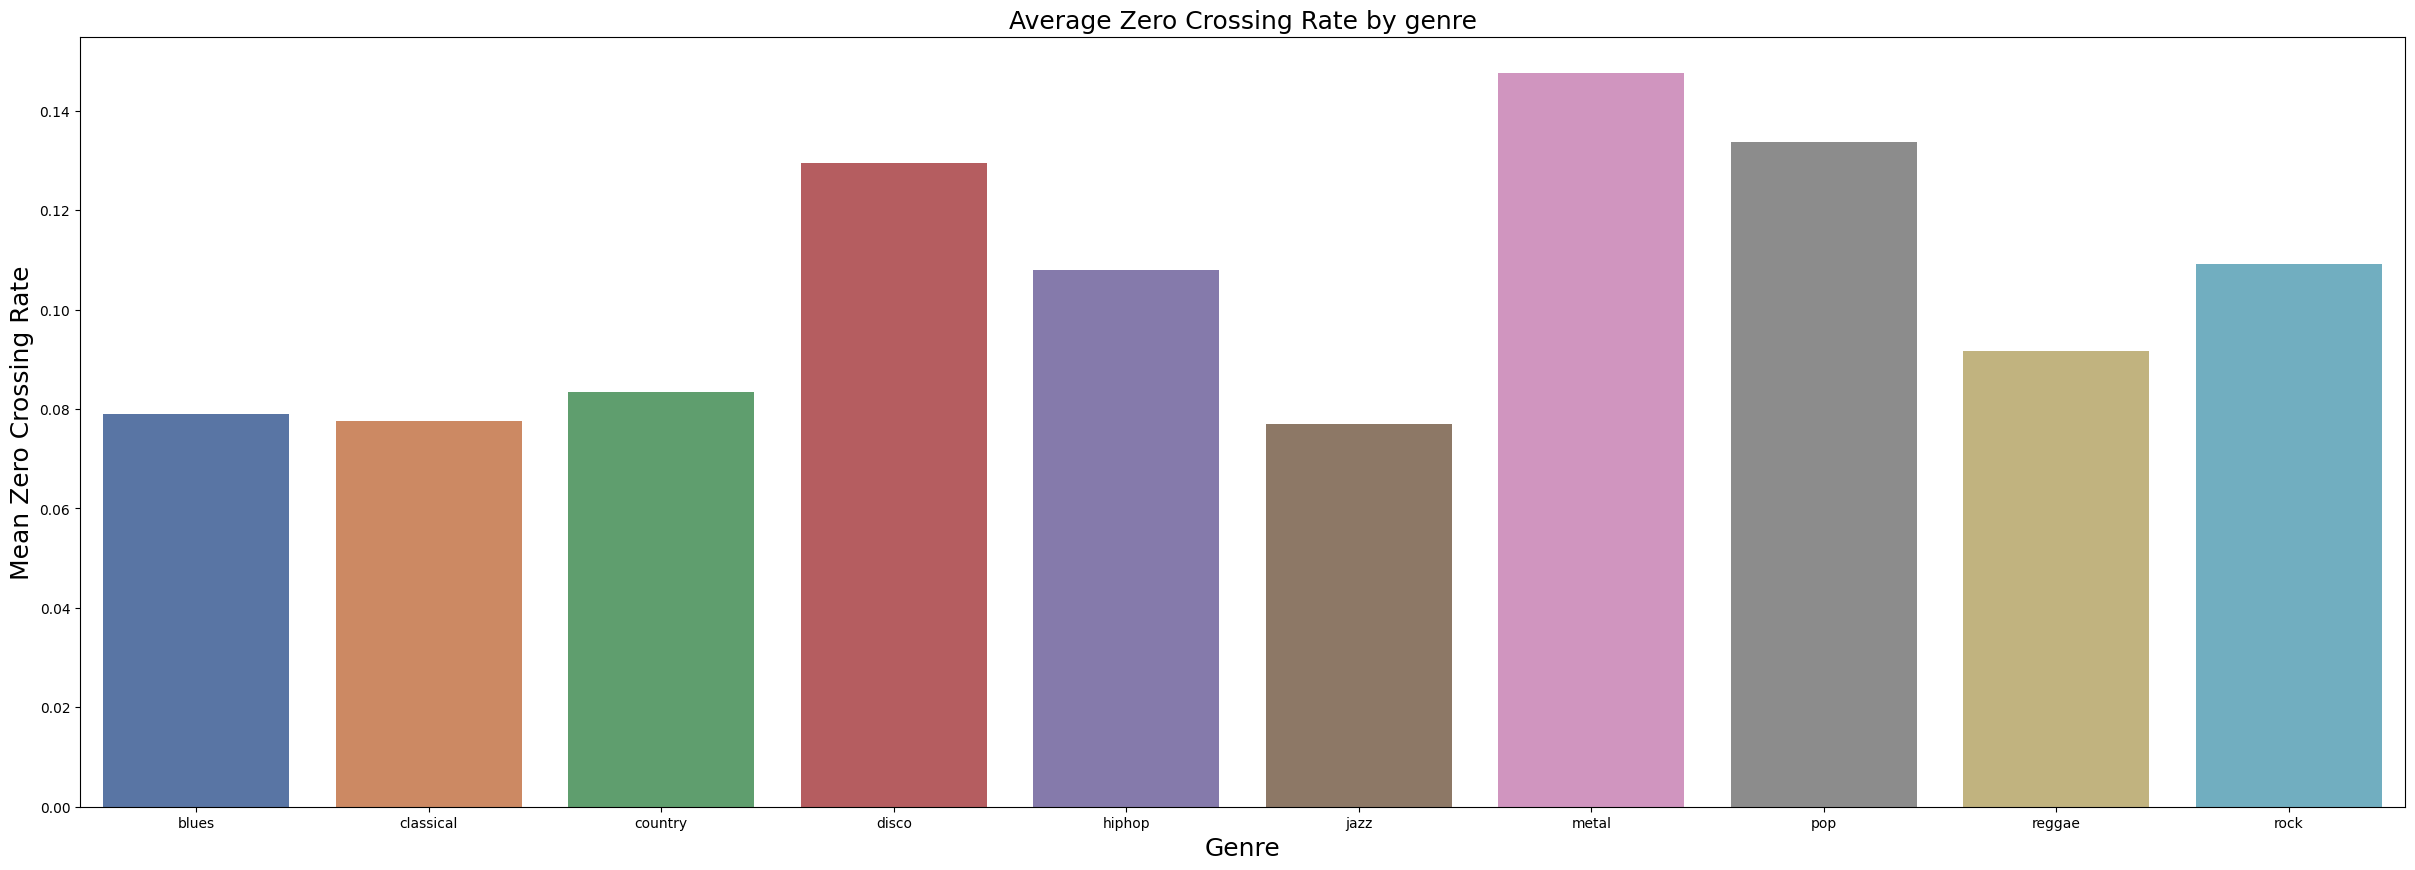

In [12]:
plt.figure(figsize=(30,10))

zero_crossing_rate = [ music_data[music_data['label']==x].zero_crossing_rate.mean() for x in genres ]

sns.barplot(x=genres, y=zero_crossing_rate, palette="deep")

plt.title("Average Zero Crossing Rate by genre", fontsize = 18)

plt.xlabel('Genre', fontsize = 18)
plt.ylabel('Mean Zero Crossing Rate', fontsize = 18)

### **Picking Relevant Features and Train Test Split**

Firstly, all the features will be used to create a linear regression model. Then RFE will be used to select the best 4 features and create a new linear regression model which should hopefully outperform the previous model. The Dataset is now ready to be split into training and testing data. 75% of the data will be used for training while 25% of the data will be used for testing.

In [13]:
X = music_data.drop(columns=['genre', 'label'])
Y = music_data['genre']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=142)

### **Training Linear Regression Model**

**The Linear Regression model ahould be able to predict the genre of the song based on the given features.**

In [14]:
linear_reg_model = linear_model.LinearRegression()
linear_reg_model.fit(X_train, Y_train)

Y_pred_lin_reg = linear_reg_model.predict(X_test)

In [15]:
mse_lin_reg = ((np.array(Y_test)-Y_pred_lin_reg)**2).sum()/len(Y_test)
root_mse_lin_reg = np.sqrt(mse_lin_reg)
r2_lin_reg = r2_score(Y_test, Y_pred_lin_reg)

print("Linear Regression Model:")
print(f"MSE: {mse_lin_reg}")
print(f"Root MSE: {root_mse_lin_reg}")
print(f"R^2 score: {r2_lin_reg}")

Linear Regression Model:
MSE: 6.499150998658022
Root MSE: 2.549343248497154
R^2 score: 0.17960066849088108


**Using RFE to determine the best features for a model:**

In [16]:
print("Using the best 4 features found through RFE:")
model_4_features = linear_model.LinearRegression()
rfe_4_features = RFE(model_4_features, n_features_to_select=4)
rfe_4_features.fit(X_train, Y_train)

selected_4_features = X_train.columns[rfe_4_features.support_]

print(f"Selected features: {selected_4_features}")
X_train_4 = X_train[selected_4_features]
X_test_4 = X_test[selected_4_features]

model_4_features.fit(X_train_4, Y_train)

# Do predictions on test set
prediction_4 = model_4_features.predict(X_test_4)

mse_4 = ((np.array(Y_test)-prediction_4)**2).sum()/len(Y_test)
root_mse_4 = np.sqrt(mse_4)
r2_4 = r2_score(Y_test, prediction_4)

print(f"MSE: {mse_4}")
print(f"Root MSE: {root_mse_4}")
print(f"R Squared: {r2_4}")

Using the best 4 features found through RFE:
Selected features: Index(['beats', 'chroma_stft', 'rmse', 'zero_crossing_rate'], dtype='object')
MSE: 7.0421805615825885
Root MSE: 2.6537107155043462
R Squared: 0.11105308581354478


### **Training KNN Model**

In [17]:
# arbitrarily choosing k
k = 5

knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train, Y_train)

Y_pred_knn = knn_model.predict(X_test)

In [18]:
mse_knn = ((np.array(Y_test)-Y_pred_knn)**2).sum()/len(Y_test)
root_mse_knn = np.sqrt(mse_knn)
r2_knn = r2_score(Y_test, Y_pred_knn)

print("KNN Model:")
print(f"MSE: {mse_knn}")
print(f"Root MSE: {root_mse_knn}")
print(f"R^2 score: {r2_knn}")

KNN Model:
MSE: 12.984
Root MSE: 3.603331791550703
R^2 score: -0.6389932965881071


**Parameter Tuning with Cross Validation:**

In [19]:
param_grid = {'n_neighbors': range(1,50,1)}
knn_clf=KNeighborsClassifier()
gs_knn = GridSearchCV(knn_clf, param_grid, scoring='accuracy', cv=KFold(n_splits=10,shuffle=True))
gs_knn.fit(X, Y)

print("Best K Value: ", gs_knn.best_params_['n_neighbors'])
print("Accuracy: %.4f\n"%gs_knn.best_score_)

Best K Value:  31
Accuracy: 0.3340



**Using K=33 and calculating MSE, RMSE, R2 scores:**

In [20]:
knn_model_tuned = KNeighborsClassifier(n_neighbors=33)
knn_model_tuned.fit(X_train, Y_train)

Y_pred_knn_tuned = knn_model_tuned.predict(X_test)

mse_knn_tuned = ((np.array(Y_test)-Y_pred_knn_tuned)**2).sum()/len(Y_test)
root_mse_knn_tuned = np.sqrt(mse_knn_tuned)
r2_knn_tuned = r2_score(Y_test, Y_pred_knn_tuned)

print("KNN Model with Tuned Hyperparameter K:")
print(f"MSE: {mse_knn_tuned}")
print(f"Root MSE: {root_mse_knn_tuned}")
print(f"R^2 score: {r2_knn_tuned}")

KNN Model with Tuned Hyperparameter K:
MSE: 11.556
Root MSE: 3.3994117138116704
R^2 score: -0.4587343295881212


### **Remarks**

The aim of this study was to be able to create a model that can classify a song into one of ten different types based on some of its inherent features. That aim seems to not be possible to achieve using the above mentioned methods, i.e. Linear Regression and KNN Classifier. The Mean Square Errors for all of the above models are pretty high, and the R^2 scores are quite low. Furthermore, the plots show that the means of most of the features are quite identical to each other hence making a highly accurate model with the current technology is not likely. However, this exercise was still not futile, since I learned quite a bit about which data types are best suited for which types of modelling.
